In [20]:
# import the necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import config
from utils import imshow, show_plot
from contrastive import ContrastiveLoss
import torchvision
from torch.autograd import Variable
from PIL import Image
import PIL.ImageOps
import os
from tqdm import tqdm
import config

In [21]:
# load the dataset
training_dir = config.training_dir
testing_dir = config.testing_dir
training_csv = config.training_csv
testing_csv = config.testing_csv
val_csv = config.val_csv
val_dir = config.val_dir

In [3]:
# preprocessing and loading the dataset
class SiameseDataset:
    def __init__(self, training_csv=None, training_dir=None, transform=None):
        # used to prepare the labels and images path
        self.train_df = pd.read_csv(training_csv)
        self.train_df.columns = ["anchor", "negative", "positive"]
        self.train_dir = training_dir
        self.transform = transform

    def __getitem__(self, index):
        # getting the image path
        image1_path = os.path.join(self.train_dir, self.train_df.iat[index, 0])
        image2_path = os.path.join(self.train_dir, self.train_df.iat[index, 1])
        image3_path = os.path.join(self.train_dir, self.train_df.iat[index, 2])

        # Loading the image
        img0 = Image.open(image1_path)
        img1 = Image.open(image2_path)
        img2 = Image.open(image3_path)

        img0 = img0.convert("L")
        img1 = img1.convert("L")
        img2 = img1.convert("L")

        # Apply image transformations
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return (
            img0,
            img1,
            img2,
        )

    def __len__(self):
        return len(self.train_df)

In [22]:
# Load the the dataset from raw image folders
siamese_dataset = SiameseDataset(
    training_csv,
    training_dir,
    transform=transforms.Compose(
        [transforms.Resize((105, 105)), transforms.ToTensor()]
    ),
)

test_dataset = SiameseDataset(
    testing_csv,
    testing_dir,
    transform=transforms.Compose(
        [transforms.Resize((105, 105)), transforms.ToTensor()]
    ),
)

eval_dataset = SiameseDataset(
    val_csv,
    val_dir,
    transform=transforms.Compose(
        [transforms.Resize((105, 105)), transforms.ToTensor()]
    ),
)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
class SiameseNetwork(nn.Module):
    """
    Siamese network for image similarity estimation.
    The network is composed of two identical networks, one for each input.
    The output of each network is concatenated and passed to a linear layer.
    The output of the linear layer passed through a sigmoid function.
    `"FaceNet" <https://arxiv.org/pdf/1503.03832.pdf>`_ is a variant of the Siamese network.
    This implementation varies from FaceNet as we use the `ResNet-18` model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_ as our feature extractor.
    In addition, we aren't using `TripletLoss` as the MNIST dataset is simple, so `BCELoss` can do the trick.
    """

    def __init__(self):
        super(SiameseNetwork, self).__init__()
        # get resnet model
        self.resnet = torchvision.models.resnet18(weights=None)

        # over-write the first conv layer to be able to read MNIST images
        # as resnet18 reads (3,x,x) where 3 is RGB channels
        # whereas MNIST has (1,x,x) where 1 is a gray-scale channel
        self.resnet.conv1 = nn.Conv2d(
            1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        )
        self.fc_in_features = self.resnet.fc.in_features

        # remove the last layer of resnet18 (linear layer which is before avgpool layer)
        self.resnet = torch.nn.Sequential(*(list(self.resnet.children())[:-1]))

        # add linear layers to compare between the features of the two images
        self.fc = nn.Sequential(
            nn.Linear(self.fc_in_features * 2, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1),
        )

        self.sigmoid = nn.Sigmoid()

        # initialize the weights
        self.resnet.apply(self.init_weights)
        self.fc.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    def forward_once(self, x):
        output = self.resnet(x)
        output = output.view(output.size()[0], -1)
        return output

    def forward(self, input1, input2, input3):
        # get two images' features
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        output3 = self.forward_once(input3)

        return output1, output2, output3

In [31]:
# Load the dataset as pytorch tensors using dataloader
train_dataloader = DataLoader(
    siamese_dataset, shuffle=True, batch_size=config.batch_size
)
eval_dataloader = DataLoader(eval_dataset, shuffle=True, batch_size=config.batch_size)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=config.batch_size)

# Declare Siamese Network
model = SiameseNetwork().to(device)
# Decalre Loss Function
criterion = nn.TripletMarginLoss(margin=1.0, p=2)
# Declare Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.0005)

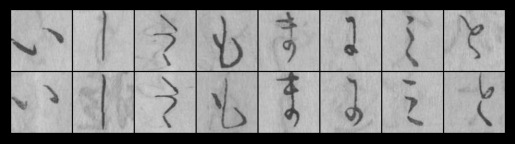

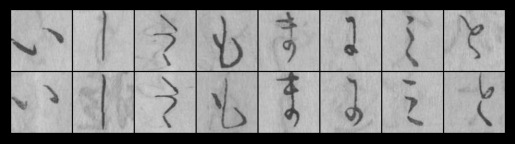

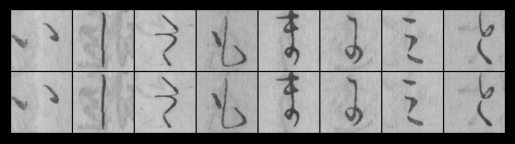

In [39]:
# Viewing the sample of images and to check whether its loading properly
vis_dataloader = DataLoader(siamese_dataset, shuffle=True, batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1]), 0)
imshow(torchvision.utils.make_grid(concatenated))

concatenated = torch.cat((example_batch[0], example_batch[2]), 0)
imshow(torchvision.utils.make_grid(concatenated))

concatenated = torch.cat((example_batch[1], example_batch[2]), 0)
imshow(torchvision.utils.make_grid(concatenated))

In [29]:
# train the model
def train(model, device, optimizer, train_dataloader, train_losses, t_correct_set):
    model.train()
    train_loss = 0
    correct = 0

    for batch_idx, (anchor, negative, positive) in enumerate(train_dataloader, 0):
        anchor, negative, positive = (
            anchor.to(device),
            negative.to(device),
            positive.to(device),
        )
        optimizer.zero_grad()
        output1, output2, output3 = model(anchor, negative, positive)
        loss = criterion(output1, output2, output3)
        train_loss += loss
        loss.backward()
        optimizer.step()

        if (batch_idx + 1) % 50 == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(output3),
                    len(train_dataloader.dataset),
                    100.0 * batch_idx / len(train_dataloader),
                    loss,
                )
            )


def eval(model, device, eval_dataloader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for images_0, images_1, images_2 in eval_dataloader:
            images_0, images_1, images_2 = (
                images_0.to(device),
                images_1.to(device),
                images_2.to(device),
            )
            output0, output1, output2 = model(images_0, images_1, images_2)
            euclidean_distance = F.pairwise_distance(output1, output2)
            pred = torch.where(
                euclidean_distance > 0.5, 1, 0
            )  # get the index of the max log-probability
            correct += len(pred) - pred.sum()

    test_loss /= len(eval_dataloader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss,
            correct,
            len(eval_dataloader.dataset),
            100.0 * correct / len(eval_dataloader.dataset),
        )
    )

In [32]:
eval(model, device, eval_dataloader)
for epoch in tqdm(range(1, config.epochs)):
    best_eval_loss = 9999
    train(model, device, optimizer, train_dataloader, epoch)
    eval(model, device, eval_dataloader)
    print("-" * 20)


Test set: Average loss: 0.0000, Accuracy: 557/557 (100%)



  0%|          | 0/19 [00:00<?, ?it/s]

Train Epoch: 1 [1568/1668 (92%)]	Loss: 1.000000


  5%|▌         | 1/19 [00:05<01:44,  5.81s/it]


Test set: Average loss: 0.0000, Accuracy: 557/557 (100%)

--------------------


  5%|▌         | 1/19 [00:06<01:58,  6.59s/it]


KeyboardInterrupt: 

In [51]:
model.eval()
test_loss = 0
correct = 0

with torch.no_grad():
    for images_1, images_2, targets in test_dataloader:
        images_1, images_2, targets = (
            images_1.to(device),
            images_2.to(device),
            targets.to(device),
        )
        output1, output2 = model(images_1, images_2)
        euclidean_distance = F.pairwise_distance(output1, output2)
        pred = torch.where(
            euclidean_distance > 0.5, 1, 0
        )  # get the index of the max log-probability
        correct += pred.eq(targets.view_as(pred)).sum().item()
print(
    "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
        test_loss,
        correct,
        len(test_dataloader.dataset),
        100.0 * correct / len(test_dataloader.dataset),
    )
)


Test set: Average loss: 0.0000, Accuracy: 1740/1820 (96%)



In [52]:
# Viewing the sample of images and to check whether its loading properly
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=8)
dataiter = iter(test_dataloader)

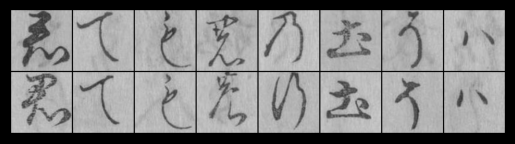

[[1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]]


In [53]:
example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1]), 0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [54]:
images_1, images_2, targets = example_batch[0], example_batch[1], example_batch[2]
images_1, images_2, targets = (
    images_1.to(device),
    images_2.to(device),
    targets.to(device),
)
output1, output2 = model(images_1, images_2)
euclidean_distance = F.pairwise_distance(output1, output2)
pred = torch.where(
    euclidean_distance > 0.5, 1, 0
)  # get the index of the max log-probability

In [55]:
euclidean_distance

tensor([1.5400, 0.1231, 0.2166, 1.2534, 0.9874, 1.7099, 0.6917, 0.0492],
       device='cuda:0', grad_fn=<NormBackward1>)

In [56]:
pred

tensor([1, 0, 0, 1, 1, 1, 1, 0], device='cuda:0')